In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Pro_Down_SR

/home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Pro_Down_SR


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
from utils import *
import random

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%cd Matrix_Downsampling/

/home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Pro_Down_SR/Matrix_Downsampling


### Upscale by 6

In [5]:
N_low = 21
N_high = 121
scale = 6
a,b,c = 8,5,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [6]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for RBF kernal
prior_sigma = 0.002
ll_sigma = 0.001

In [8]:
G = np.eye(N_high**2) * prior_sigma**2
G_inverse = np.eye(N_high**2) * (1/prior_sigma**2)

# Code downscaling matrix
H = np.zeros((N_low*N_low, N_high*N_high))

submatrix = np.zeros((N_low,N_high))
for i in range(N_low):
    submatrix[i,scale*i] = 1
    
for j in range(N_low):
    H[N_low*j:N_low*(j+1),N_high*scale*j:N_high*(scale*j+1)] = submatrix
    
# Turn matrices to tensors
G = torch.tensor(G).to(torch.float32).to(device)
G_inverse = torch.tensor(G_inverse).to(torch.float32).to(device)
H = torch.tensor(H).to(torch.float32).to(device)
A_high = torch.tensor(create_A(N_high)).to(torch.float32).to(device)
b_high = torch.tensor(create_forcing_term(N_high,a,b,c)).to(torch.float32).to(device)

# Store sparse matrices as sparse tensor
A_high = A_high.to_sparse()
H = H.to_sparse()
G = G.to_sparse()
G_inverse = G_inverse.to_sparse()
operator = torch.spmm(A_high.T,G_inverse).to(device)

In [9]:
x = torch.tensor(w_low).to(torch.float32).to(device)
posterior_initial = torch.randn(*[N_high,N_high]).to(torch.float32).to(device)

In [37]:
G = ResidualLearning().to(device)
# G.load_state_dict(torch.load('models/langevin_residual_learning/lr0.005_gamma0.5_stepsize20_K25000/ckpt/best_model.pth')['netG'])
G.load_state_dict(torch.load('models/model4/21_121/lr0.003_gamma0.5_stepsize50_K15000_llsigma_0.002_psigma_0.002/ckpt/current_epoch.pth')['netG'])

<All keys matched successfully>

In [38]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
observation = torch.spmm(H,w_high_tensor.reshape(N_high**2,1)).reshape(N_low,N_low)
out = G(w_low_tensor.reshape(1,N_low,N_low))
residual = w_low_tensor-observation

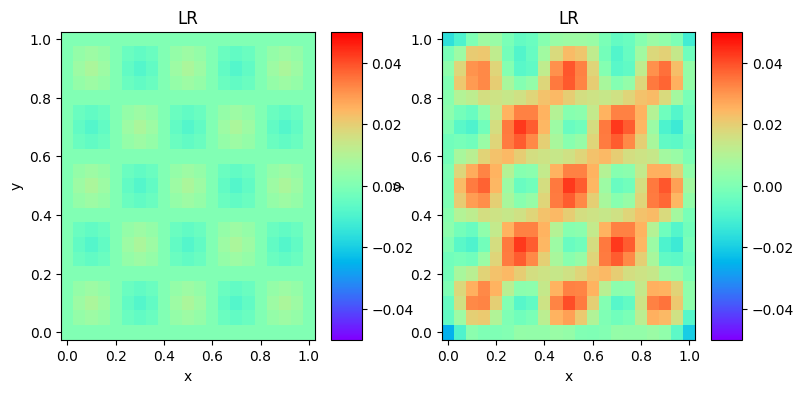

In [39]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, residual.cpu().data.numpy(), cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [163]:
# Parameters for Langevin dynamics
K = 4000
s = 0.0004

z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    observation = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
    x_hat = observation + G(x.reshape(1,N_low,N_low)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    # chains_evolution.append(z.cpu().data.numpy())   

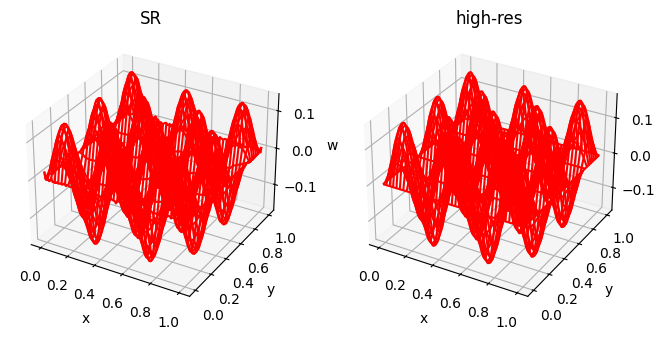

In [164]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [165]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.0003125364795143987
